# AI Bubble Predictor with a multi-output LSTM model

AI is a very trendy topic nowadays. Everyone is talking about it, and we hear about it everywhere. But can it really deliver on its promises?

I don't think so. I think that AI is just a bubble that will burst soon. It's a great technology, but it's not as powerful as people think. As any tool, it has its limitations — and those have been overlooked by many.

In this project, I will build a model to predict when the AI bubble will burst. I will use historical data about a phenomenon I believe was similar to the AI bubble (the dot-com bubble) to train an LSTM model. Then, I will use this model to generate a hypothesis about when the AI bubble will burst.

I hope this project will help people understand the limitations of AI and avoid the consequences of the burst of the AI bubble.

## Getting the data

In [1]:
# First, get stock market data about the dot-com bubble

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

# Get the stock data
full_timeframe_start = datetime.datetime(1990, 1, 1)
full_timeframe_end = datetime.datetime(2012, 1, 1)
companies = ['MSFT', 'AAPL', 'AMZN', 'INTL', 'ORCL', 'INTC', 'QCOM', 'HPQ', 'EBAY', 'VZ', 'T', 'GOOGL', 'FB', 'TWTR', 'SNAP', 'TSLA', 'NFLX', 'DIS', 'CMCSA', 'FOXA', 'DISCA', 'VIAC', 'NWSA', 'NWS', 'CBS']
stock_data = yf.download(tickers=companies, start=full_timeframe_start, end=full_timeframe_end)
# Remove those columns that have any NaN values
stock_data = stock_data.dropna(axis=1)
companies = stock_data.columns.get_level_values(1).unique()
num_companies = len(companies)
print(f"Number of companies: {num_companies}")

# Save the data to a CSV file
stock_data.to_csv('stock_data.csv')

display(stock_data.head())

[*********************100%%**********************]  24 of 25 completed

10 Failed downloads:
['VIAC', 'CBS', 'DISCA', 'FB', 'TWTR']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['NWS', 'NWSA', 'FOXA', 'INTL', 'SNAP']: YFChartError("%ticker%: Data doesn't exist for startDate = 631170000, endDate = 1325394000")


Number of companies: 9


Price      Adj Close                                                    \
Ticker          AAPL     CMCSA       DIS       HPQ      INTC      MSFT   
Date                                                                     
1990-01-02  0.262722  1.311940  6.913753  1.186972  0.627263  0.380704   
1990-01-03  0.264485  1.321378  6.928715  1.165937  0.609839  0.382849   
1990-01-04  0.265367  1.293063  6.921234  1.153918  0.622907  0.394109   
1990-01-05  0.266248  1.264748  6.943681  1.138893  0.618551  0.384457   
1990-01-08  0.268012  1.274186  7.003301  1.159927  0.627263  0.390355   

Price                                        Close  ...       Open     Volume  \
Ticker          ORCL         T        VZ      AAPL  ...         VZ       AAPL   
Date                                                ...                         
1990-01-02  0.483362  1.427554  5.244071  0.332589  ...  25.124830  183198400   
1990-01-03  0.430768  1.402752  5.232570  0.334821  ...  25.630699  207995200   
1990-01-04  0.443290  1.391255  5.080447  0.335938  ...  25.293453  221513600   
1990-01-05  0.418246  1.324206  4.964323  0.337054  ...  24.478441  123312000   
1990-01-08  0.433273  1.346555  5.004966  0.339286  ...  23.832052  101572800   

Price                                                                   \
Ticker        CMCSA      DIS       HPQ      INTC       MSFT       ORCL   
Date                                                                     
1990-01-02  2633400  6983477  11561381  63833600   53035200   35510400   
1990-01-03  2278800  8077040  12022920  69504000  113774400  179844300   
1990-01-04  3684600  7721845   6810346  58483200  125740800  125278650   
1990-01-05   976500  3961885   5281277  37036800   69566400   51017850   
1990-01-08  2363400  6647745   5903122  43305600   58982400   33161400   

Price                         
Ticker            T       VZ  
Date                          
1990-01-02  3622994  1304092  
1990-01-03  3306822  1014986  
1990-01-04  3264454  1331669  
1990-01-05  3073269  1611435  
1990-01-08  2713670  1051458  

[5 rows x 54 columns]

## Training the LSTM model

In [2]:
# Here, we'll transform the data to make it easier to work with. We'll calculate the daily returns for each stock.
# We'll also calculate the average daily return for the dot-com bubble period.
# Finally, we'll calculate the average daily return for the period after the dot-com bubble.

# Calculate the daily returns
stock_data['Adj Close'].pct_change()
print(f'Stock data shape: {stock_data.shape}')

# Calculate the average daily return for the dot-com bubble period
dot_com_bubble_start = full_timeframe_start
dot_com_bubble_end = datetime.datetime(2002, 1, 1)

dot_com_bubble_returns = stock_data.loc[dot_com_bubble_start:dot_com_bubble_end]['Adj Close'].pct_change().mean()

# Calculate the average daily return for the period after the dot-com bubble
post_dot_com_bubble_start = dot_com_bubble_end
post_dot_com_bubble_end = full_timeframe_end

post_dot_com_bubble_returns = stock_data.loc[post_dot_com_bubble_start:post_dot_com_bubble_end]['Adj Close'].pct_change().mean()

print('Average daily return for the dot-com bubble period:', dot_com_bubble_returns)
print('Average daily return for the period after the dot-com bubble:', post_dot_com_bubble_returns)

Stock data shape: (5547, 54)
Average daily return for the dot-com bubble period: Ticker
AAPL     0.000709
CMCSA    0.000986
DIS      0.000480
HPQ      0.000884
INTC     0.001502
MSFT     0.001597
ORCL     0.001812
T        0.000622
VZ       0.000474
dtype: float64
Average daily return for the period after the dot-com bubble: Ticker
AAPL     0.001723
CMCSA    0.000299
DIS      0.000478
HPQ      0.000366
INTC     0.000227
MSFT     0.000173
ORCL     0.000522
T        0.000308
VZ       0.000296
dtype: float64


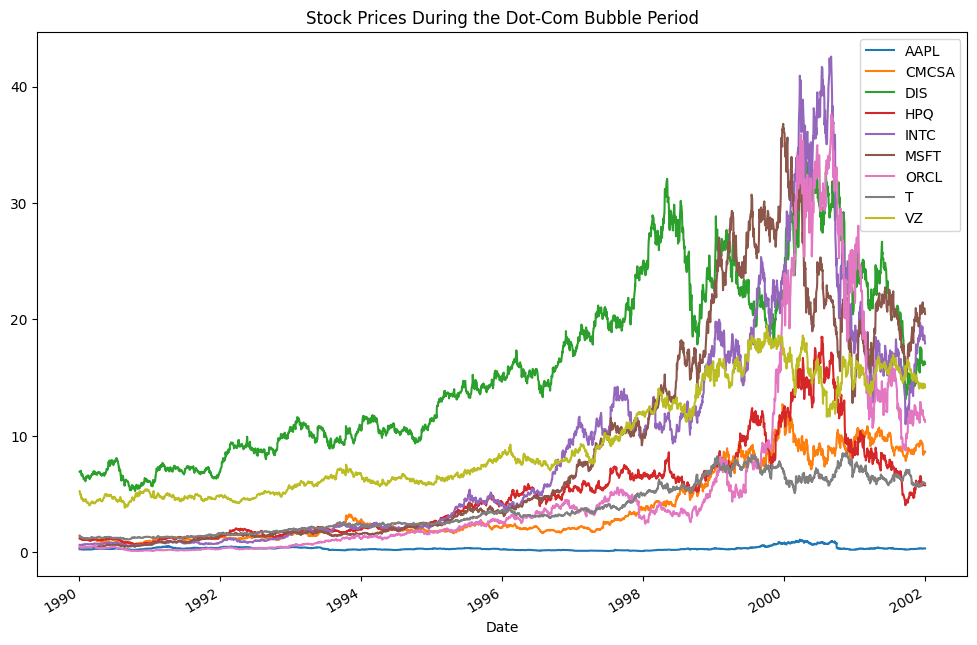

In [3]:
# Now, let's plot the stock prices for each company during the dot-com bubble period.
# We'll also plot the average daily return for the dot-com bubble period and the period after the dot-com bubble.

# Plot the stock prices for each company during the dot-com bubble period
stock_data.loc[dot_com_bubble_start:dot_com_bubble_end]['Adj Close'].plot(figsize=(12, 8))
plt.title('Stock Prices During the Dot-Com Bubble Period')
plt.legend(companies)
plt.show()

In [4]:
# Now, use the transformed data to train an LSTM model to predict the stock prices for the next day.

# First, we'll normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data["Adj Close"])
print(f"Scaled data shape: {scaled_data.shape}")

import torch


# Now, we'll create the input and output sequences for the LSTM model
def create_sequences(data, past_timesteps, future_timesteps):
    X, y = [], []
    for i in range(len(data) - past_timesteps - future_timesteps + 1):
        X.append(data[i : i + past_timesteps])
        y.append(data[i + past_timesteps : i + past_timesteps + future_timesteps])
    X = torch.FloatTensor(X)
    y = torch.FloatTensor(y)  # Convert the data to PyTorch tensors
    return X, y


seq_length_max = (
    120
)  # i.e. the model will look at the previous ___ days to predict the next days
past_timesteps = seq_length_max // 2  # half of the timesteps are in the past
future_timesteps = seq_length_max // 2  # half of the timesteps are in the future


X, y = create_sequences(
    scaled_data, past_timesteps=past_timesteps, future_timesteps=future_timesteps
)

# We need to create the sequences before splitting the data into training and testing sets, as the sequences need to be continuous
# If we split the data first, the sequences would be broken up and the model wouldn't be able to learn from them
# Now, we'll split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)  # This keeps the sequences continuous

print(f"Type of X_train: {type(X_train)}")
print(f"Type of y_train: {type(y_train)}")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Now, check that the first element from each sequence in X_train + y_train +  X_test + y_test corresponds to an element in scaled_data
reconstructed_data = torch.cat(
    (
        X_train[:, 0, :],  # The first element in each sequence in X_train
        y_train[-1, :, :],  # Add the last element in the last sequence in y_train
        X_test[seq_length_max:, 0, :],  # The first element in each sequence in X_test
        y_test[-1, :, :],  # Add the last element in the last sequence in y_test
    ),
    dim=0,
)
# assert torch.equal(reconstructed_data, torch.FloatTensor(scaled_data))

Scaled data shape: (5547, 9)
Type of X_train: <class 'torch.Tensor'>
Type of y_train: <class 'torch.Tensor'>
X_train shape: torch.Size([4342, 60, 9])
y_train shape: torch.Size([4342, 60, 9])
X_test shape: torch.Size([1086, 60, 9])
y_test shape: torch.Size([1086, 60, 9])


/var/folders/g5/qwphv0rn5tvflncj75xsxvxw0000gn/T/ipykernel_27415/798226301.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  X = torch.FloatTensor(X)


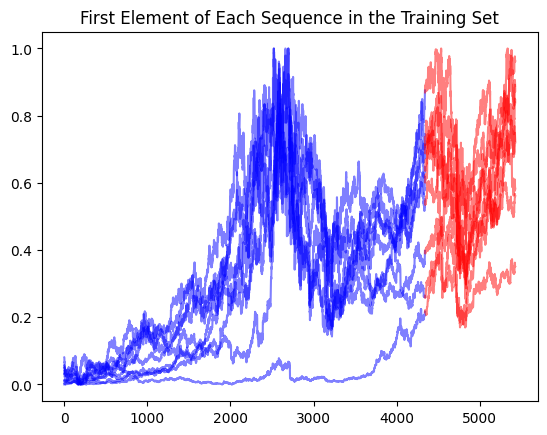

In [5]:
# Plot the first element of each sequence in the training set in blue, then plot the first element of each sequence in the testing set in red
# This verifies that the sequences are continuous in a visual way
plt.plot(range(len(X_train)), X_train[:, 0], label='Training set', color='blue', alpha=0.5)
plt.plot(range(len(X_train), len(X_train) + len(X_test)), X_test[:, 0], label='Testing set', color='red', alpha=0.5)
plt.title('First Element of Each Sequence in the Training Set')
plt.show()

In [6]:
# Now, we'll build the LSTM model with Keras
import os
# os.environ["KERAS_BACKEND"] = "torch"
import keras
import torch
import torch.nn as nn
from keras import backend as K
import random
import tensorflow as tf

print(f"Available GPUs: {tf.config.experimental.list_physical_devices('GPU')}")

# Ensure reproducibility

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

num_features = 1  # We only have one feature: the stock price

model = keras.Sequential()
model.add(
    keras.layers.LSTM(
        units=150,
        activation="relu",
        input_shape=(past_timesteps, num_features),
        return_sequences=True,
    )
)
model.add(
    keras.layers.Dense(units=100, activation="relu")
)  # This is a layer that interprets the output of the LSTM layer
model.add(
    keras.layers.Dense(units=future_timesteps)
)  # This is a layer that interprets the output of the LSTM layer

Available GPUs: []


/Users/aldan.creo/repos/ai-bubble-predictor/.conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Compile the model. Use early stopping to prevent overfitting
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
print(model.summary())

# Right now, X_train has shape (num_sequences, past_timesteps, num_companies)
# Reshape into (num_sequences * num_companies, past_timesteps, num_features)
X_train = X_train.reshape(-1, past_timesteps, num_features)
# Same for y_train
y_train = y_train.reshape(-1, future_timesteps, num_features)

es = keras.callbacks.EarlyStopping(
    monitor="val_mae", mode="min", verbose=1, patience=25, restore_best_weights=True
)

# Train the model
model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    verbose=True,
    validation_split=0.2,  # Use 20% of the training data for validation
    callbacks=[es],
)

# Save the model
model.save("multistep_lstm_model.keras")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 150)        │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60, 100)        │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60, 60)         │         6,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,360 (438.91 KB)

 Trainable params: 112,360 (438.91 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - loss: 0.0423 - mae: 0.1370 - val_loss: 0.0035 - val_mae: 0.0452
Epoch 2/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 27s 111ms/step - loss: 0.0050 - mae: 0.0446 - val_loss: 0.0029 - val_mae: 0.0419
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - loss: 0.0044 - mae: 0.0411 - val_loss: 0.0029 - val_mae: 0.0409
Epoch 4/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 29s 117ms/step - loss: 0.0043 - mae: 0.0405 - val_loss: 0.0030 - val_mae: 0.0414
Epoch 5/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - loss: 0.0042 - mae: 0.0396 - val_loss: 0.0045 - val_mae: 0.0491
Epoch 6/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - loss: 0.0039 - mae: 0.0390 - val_loss: 0.0048 - val_mae: 0.0515
Epoch 7/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 29s 118ms/step - loss: 0.0038 - mae: 0.0386 - val_loss: 0.0077 - val_mae: 0.0681
Epoch 8/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 29s 118ms/step - loss: 0.0037 - mae: 0.0384 - val_loss: 0.0054 - val_mae: 0.0547
Epoch 9/100
245/245

In [ ]:
# load multistep_lstm_model.keras
model = keras.models.load_model("multistep_lstm_model.keras")

# Right now, X_train has shape (num_sequences, past_timesteps, num_companies)
# Reshape into (num_sequences * num_companies, past_timesteps, num_features)
X_test = X_test.reshape(-1, past_timesteps, num_features)
# Same for y_test
y_test = y_test.reshape(-1, future_timesteps, num_features)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print("Mean Absolute Error on Test Set:", mae)

In [16]:
# Now, we'll use the model to predict the stock prices for the next day
# We'll start by predicting the stock prices for the next day in the training set
# Then, we'll predict the stock prices for the next day in the testing set

# Predict the stock prices for the next day in the training set
y_train_pred = torch.FloatTensor(model.predict(X_train))
# Reshape into (num_sequences, future_timesteps, num_companies)
y_train_pred = y_train_pred.view(-1, future_timesteps, num_companies)

# Predict the stock prices for the next day in the testing set
y_test_pred = torch.FloatTensor(model.predict(X_test))
# Reshape into (num_sequences, future_timesteps, num_companies)
y_test_pred = y_test_pred.view(-1, future_timesteps, num_companies)

# Take only the first element of each sequence
y_train_first_element = y_train.view(-1, future_timesteps, num_companies)[:, 0, :]
y_train_pred_first_element = y_train_pred[:, 0, :]
y_test_first_element = y_test.view(-1, future_timesteps, num_companies)[:, 0, :]
y_test_pred_first_element = y_test_pred[:, 0, :]

# Inverse transform the data
y_train_first_element = scaler.inverse_transform(y_train_first_element)
y_train_pred_first_element = scaler.inverse_transform(y_train_pred_first_element)

y_test = scaler.inverse_transform(y_test_first_element)
y_test_pred_first_element = scaler.inverse_transform(y_test_pred_first_element)

# Calculate the Mean Absolute Error for the training set
mae_train = np.mean(np.abs(y_train - y_train_pred))
print("Mean Absolute Error on Training Set:", mae_train)

# Calculate the Mean Absolute Error for the testing set
mae_test = np.mean(np.abs(y_test - y_test_pred))
print("Mean Absolute Error on Testing Set:", mae_test)

# Plot the stock prices for the next day in the training set
plt.figure(figsize=(12, 8))
plt.plot(y_train, label="True", color="blue")
plt.plot(y_train_pred, label="Predicted", color="red")
plt.title("Stock Prices for the Next Day in the Training Set")
plt.legend()
plt.show()

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step


RuntimeError: The size of tensor a (39078) must match the size of tensor b (260520) at non-singleton dimension 0

In [ ]:
# Load the model from the file
model = LSTM(
    input_size=1,
    hidden_layer_size=hidden_layer_size,
    output_size=1,
    num_layers=num_layers,
    device=device,
)
model.load_state_dict(torch.load("lstm_model.pt"))

# Evaluate the model
model.eval()

# Make predictions. We'll get num_companies predictions for each test sequence.
print(f"X_test shape: {X_test.shape}")
# X_test: (num_sequences, seq_length_max, num_companies)
with torch.no_grad():
    y_pred = model(X_test.view(-1, seq_length_max, 1))
    y_pred = y_pred.view(-1, seq_length_max, num_companies)
    print(f"y_pred shape: {y_pred.shape}")

# Calculate the loss
all_predictions = y_pred
print("Loss:", loss.item())
# Calculate the average difference between the predicted and actual stock prices
average_diff = torch.mean(torch.abs(all_predictions[:, -1, ...] - y_test[:, -1, ...]))
print("Average difference:", average_diff.item())

# Finally, we'll plot the predicted stock prices for the next day.
# We'll also plot the actual stock prices for the test data.

# Choose a color map so that each company has a different color and the colors are the same for the predicted and actual stock prices
cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(num_companies)] # These are rbga colors

# Plot the percentage change in stock prices for each company
# Use the colors defined above to plot the predicted and actual stock prices for each company
for i in range(num_companies):
    plt.figure(figsize=(12, 8))
    plt.plot(all_predictions[:, -1, i].cpu().numpy(), label=f"{companies[i]} (pred)", linestyle="--", color=colors[i], alpha=0.5)
    plt.plot(y_test[:, -1, i].cpu().numpy(), label=f"{companies[i]} (actual)", color=colors[i], alpha=0.5)
    # y range: -1 to 1
    plt.ylim(-1, 1)
    plt.xlabel("Day")
    plt.ylabel("Stock Price")
    plt.title("Predicted vs. Actual Stock Prices")
    plt.legend()
    plt.show()

In [ ]:
# Inverse transform the data
y_test_pred = scaler.inverse_transform(all_predictions.cpu().numpy())
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())

# Plot the predicted stock prices for the next day
for i in range(5):
    plt.figure(figsize=(12, 8))
    plt.plot(y_test_pred[:, i], label=f"{companies[i]} (pred)", linestyle="--", color=colors[i])
    plt.plot(y_test_actual[:, i], label=f"{companies[i]} (actual)", color=colors[i])
    plt.xlabel("Day")
    plt.ylabel("Stock Price")
    plt.title("Predicted vs. Actual Stock Prices")
    plt.legend()
    plt.show()

In [ ]:
starting_sequence = X_test[0, ...].unsqueeze(dim=0) # First sequence of the first company
num_to_generate = X_test.shape[0] - seq_length_max # We want to generate the rest of the test data, i.e. what's remaining after this first sequence
with torch.no_grad():
    generations = model.generate_predictions(starting_sequence, num_to_generate)
display(generations)

# Plot the percentage change in stock prices for each company
for i in range(1):
    plt.figure(figsize=(12, 8))
    plt.plot(y_test[:, i].cpu().numpy(), label=f"{companies[i]} (actual)", color=colors[i])
    # Draw a vertical line after the ending of the prompt (seq_length_max)
    plt.axvline(x=seq_length_max, color='black', linestyle='--')
    plt.plot(range(seq_length_max, seq_length_max + num_to_generate), generations[0, seq_length_max:, i].cpu().numpy(), label=f"{companies[i]} (pred)", linestyle="--", color=colors[i])
    plt.ylim(-1, 1)
    plt.xlabel("Day")
    plt.ylabel("Stock Price")
    plt.title("Predicted vs. Actual Stock Prices")
    plt.legend()
    plt.show()